In [41]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import mofapy2

print("scipy version:", scipy.__version__)
print("mofapy2 version:", mofapy2.__version__)

from mofapy2.run.entry_point import entry_point

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

scipy version: 1.14.1
mofapy2 version: 0.7.2


In [42]:
# Import data (Ages 8 to 40 with IIV vaccination, first visit only)
data = pd.read_csv("initial_dataset_20240715.csv")
data

,donor_id,outcome,age,bmi,gender,race,assay,data_name,subset,data
0,347,0,25.18,20.15,Female,Caucasian,7,IFNa_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,710.0
1,347,0,25.18,20.15,Female,Caucasian,7,IFNg_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,364.0
2,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_10_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,406.0
3,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_2_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,401.0
4,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_21_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,439.0
...,...,...,...,...,...,...,...,...,...,...
42554,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_2_Mono_pSTAT5,Mono: pSTAT5,554.0
42555,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_21_Mono_pSTAT5,Mono: pSTAT5,592.0
42556,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_6_Mono_pSTAT5,Mono: pSTAT5,556.0
42557,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_7_Mono_pSTAT5,Mono: pSTAT5,646.0


## Data Preprocessing

### Formatting of data into MoFA structure

In [43]:
# Rename columns to fit in MoFA terminology
data_mofa = data.rename(columns={"donor_id": "sample", 
                                 "data_name": "feature", 
                                 "data": "value", 
                                 "assay":"view", 
                                 "outcome":"group"})
data_mofa

,sample,group,age,bmi,gender,race,view,feature,subset,value
0,347,0,25.18,20.15,Female,Caucasian,7,IFNa_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,710.0
1,347,0,25.18,20.15,Female,Caucasian,7,IFNg_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,364.0
2,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_10_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,406.0
3,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_2_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,401.0
4,347,0,25.18,20.15,Female,Caucasian,7,IL_neg_21_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,439.0
...,...,...,...,...,...,...,...,...,...,...
42554,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_2_Mono_pSTAT5,Mono: pSTAT5,554.0
42555,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_21_Mono_pSTAT5,Mono: pSTAT5,592.0
42556,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_6_Mono_pSTAT5,Mono: pSTAT5,556.0
42557,270,0,13.57,29.15,Female,Caucasian,7,IL_neg_7_Mono_pSTAT5,Mono: pSTAT5,646.0


In [44]:
# Connect view numbers to corresponding assay names
conditions = [
    (data_mofa['view'] == 1),
    (data_mofa['view'] == 2),
    (data_mofa['view'] == 3),
    (data_mofa['view'] == 4),
    (data_mofa['view'] == 5),
    (data_mofa['view'] == 6),
    (data_mofa['view'] == 7),
    (data_mofa['view'] == 9),
    (data_mofa['view'] == 10),
    (data_mofa['view'] == 11),
    (data_mofa['view'] == 12),
    (data_mofa['view'] == 13),
    (data_mofa['view'] == 14),
    (data_mofa['view'] == 15),
    (data_mofa['view'] == 16)
]

values = ["CMV_EBV",
          "Other_immunoassay",
          "Human_Luminex 62_63 plex",
          "CyTOF_phenotyping",
          "HAI",
          "Human_Luminex_51_plex",
          "Phospho_flow_cytokine_stim_(PBMC)",
          "pCyTOF_(whole_blood)_pheno",
          "pCyTOF_(whole_blood)_phospho",
          "CBCD",
          "Human_MSD_4_plex",
          "Lyoplate_1",
          "Human_MSD_9_plex",
          "Human_Luminex_50_plex",
          "Other_Luminex"
         ]

data_mofa['assay'] = np.select(conditions, values, default = "Not Assigned")

data_mofa = data_mofa.rename(columns = {'assay':'view', 'view': 'view_num'})

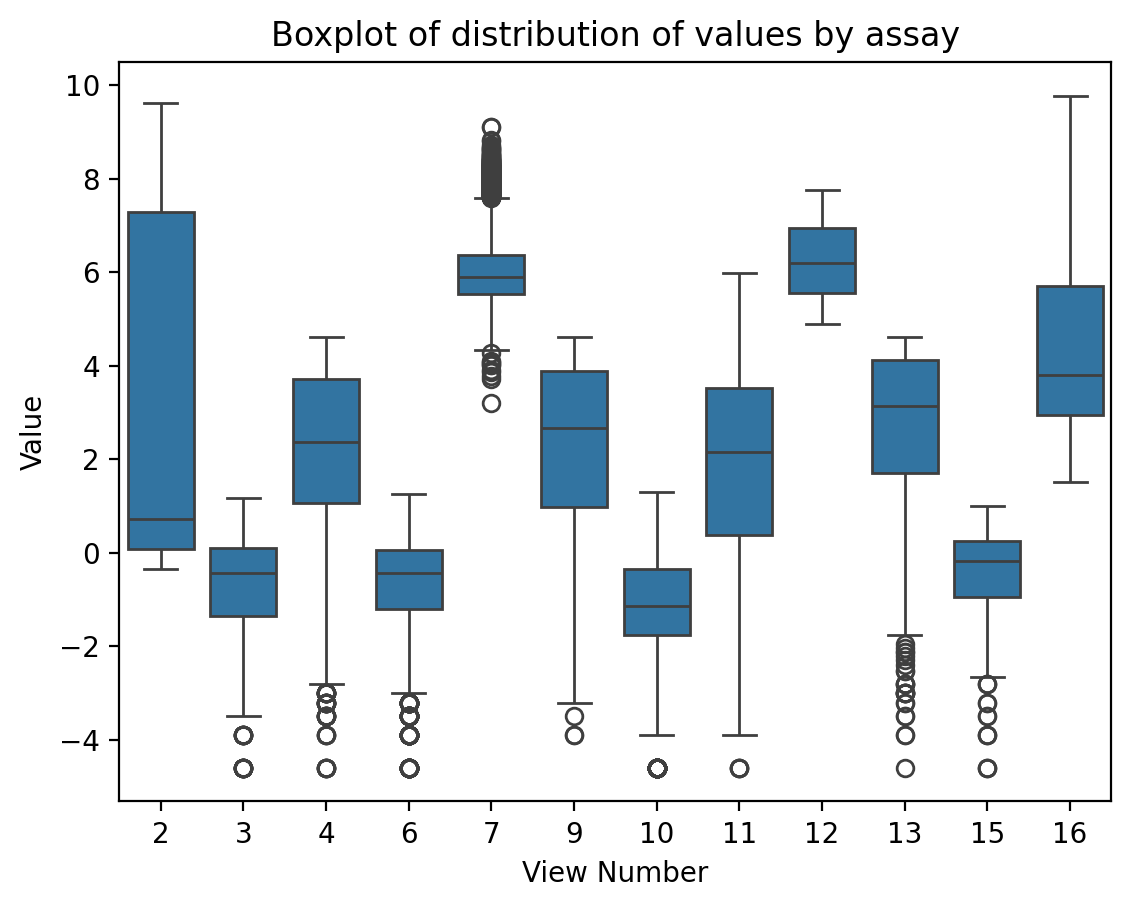

In [45]:
# Graph distribution of values for each view (assay)
sns.boxplot(x=data_mofa['view_num'], y=np.log(data_mofa['value']), data=data_mofa)
plt.xlabel('View Number')
plt.ylabel('Value')
plt.title('Boxplot of distribution of values by assay')
plt.show()

### Scaling & Removing Of Outliers

In [46]:
scaler = StandardScaler()

# Scale values by view
def scale_values(group):
    group['scaled_value'] = scaler.fit_transform(group[['value']])
    return group

data_mofa_scaled = data_mofa.groupby('view').apply(scale_values)
data_mofa_scaled.reset_index(drop = True, inplace = True)

# Set scaled value as value for MoFA
data_mofa_scaled.rename(columns = {'value': 'nonscaled_value', 'scaled_value':'value'}, inplace = True)
data_mofa_scaled

,sample,group,age,bmi,gender,race,view_num,feature,subset,nonscaled_value,view,value
0,347,0,25.18,20.15,Female,Caucasian,11,BASO_,Basophil-%,0.40,CBCD,-0.511175
1,347,0,25.18,20.15,Female,Caucasian,11,BASO_CT,Basophil Absolute Count-K/uL,0.02,CBCD,-0.517414
2,347,0,25.18,20.15,Female,Caucasian,11,CELL_HEMOGL,Mean Cell Hemoglobin-pg/cell,29.50,CBCD,-0.033419
3,347,0,25.18,20.15,Female,Caucasian,11,CELL_HEMOGL_CONC,Mean Cell Hemoglobin Concentration-g/dL,33.80,CBCD,0.037177
4,347,0,25.18,20.15,Female,Caucasian,11,CELL_VOL,Mean Cell Volume-femtoliter,87.30,CBCD,0.915526
...,...,...,...,...,...,...,...,...,...,...,...,...
42554,190,0,10.36,NaN,Female,Other,10,IL_neg_7_transitional_B_cells_pSTAT1,CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.17,pCyTOF_(whole_blood)_phospho,-0.318097
42555,190,0,10.36,NaN,Female,Other,10,LPS_transitional_B_cells_pSTAT1,CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.16,pCyTOF_(whole_blood)_phospho,-0.336802
42556,190,0,10.36,NaN,Female,Other,10,PMA_Iono_transitional_B_cells_pSTAT1,CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.14,pCyTOF_(whole_blood)_phospho,-0.374214
42557,190,0,10.36,NaN,Female,Other,10,Unstim_transitional_B_cells_pSTAT1,CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.21,pCyTOF_(whole_blood)_phospho,-0.243273


In [47]:
# Remove outliers 1.5 IQR beyond Q1 and Q3
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR # Define bounds for outliers
    upper_bound = Q3 + 1.5*IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Apply outlier removing on each view
cleaned_data_mofa = data_mofa_scaled.groupby('view').apply(remove_outliers, 'value').reset_index(drop=True)

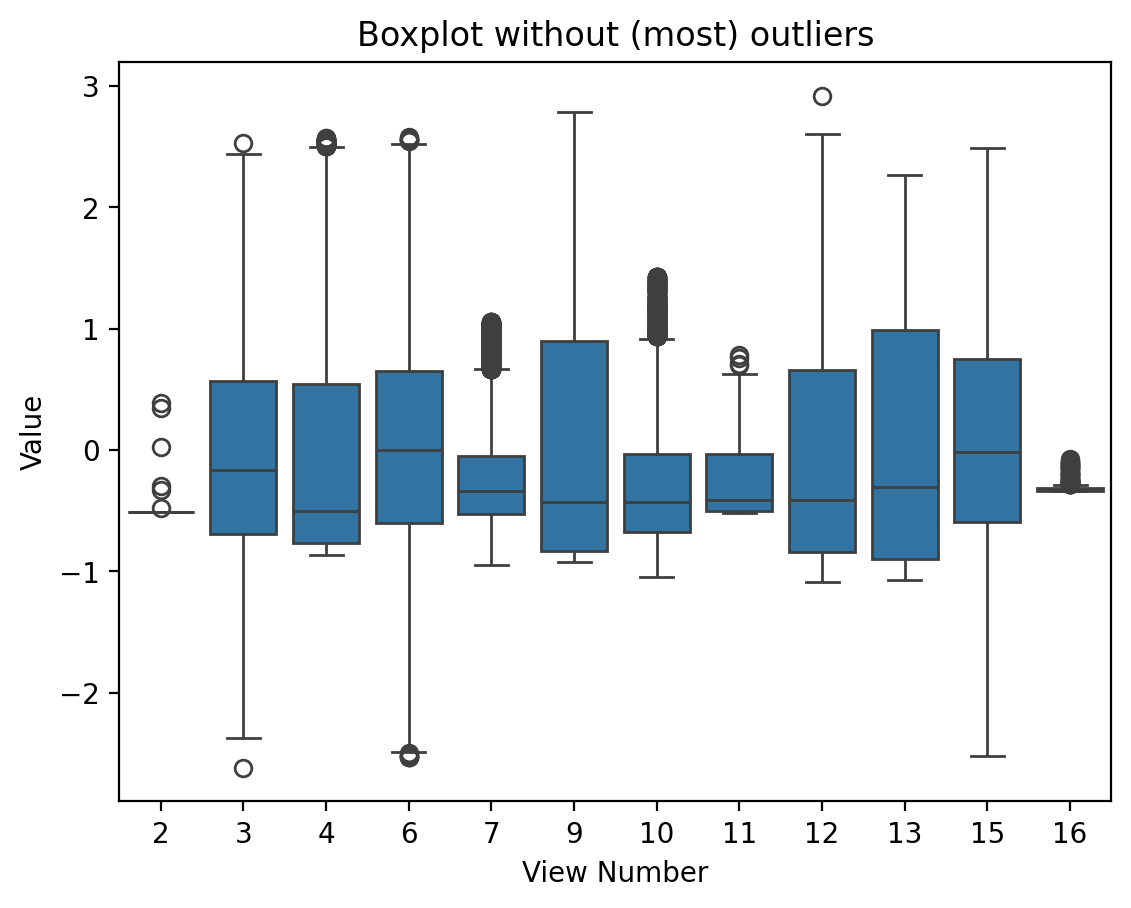

In [48]:
# Graph of data values after scaling and removing of (most) outliers
sns.boxplot(x='view_num', y = 'value', data=cleaned_data_mofa)
plt.xlabel('View Number')
plt.ylabel('Value')
plt.title('Boxplot without (most) outliers')
plt.show()

In [49]:
feature_counts = cleaned_data_mofa.groupby('view')['feature'].nunique()
print(feature_counts)

view
CBCD                                   18
CyTOF_phenotyping                      76
Human_Luminex 62_63 plex               63
Human_Luminex_50_plex                  49
Human_Luminex_51_plex                  51
Human_MSD_4_plex                        4
Lyoplate_1                             65
Other_Luminex                          38
Other_immunoassay                       2
Phospho_flow_cytokine_stim_(PBMC)     274
pCyTOF_(whole_blood)_pheno            312
pCyTOF_(whole_blood)_phospho         2286
Name: feature, dtype: int64


### Combining Luminex assays

In [50]:
# Define the views for which we want to remove the prefix from 'feature'
luminex_views = ["Human_Luminex_50_plex", "Human_Luminex_51_plex"]

# Function to remove the prefix 'L_50' from feature values
def remove_prefix(feature):
    if feature.startswith("L50_"):
        return feature[4:]  # Remove the first four characters ("L_50")
    return feature

# Apply the function to update 'feature' conditionally based on 'view'
cleaned_data_mofa.loc[cleaned_data_mofa['view'].isin(luminex_views), 'feature'] = (
    cleaned_data_mofa.loc[cleaned_data_mofa['view'].isin(luminex_views), 'feature']
    .apply(remove_prefix)
)

In [51]:
# Specify the views of interest
luminex_views = ["Human_Luminex 62_63 plex", "Human_Luminex_50_plex", "Human_Luminex_51_plex"]

# Group by 'view' and aggregate 'feature' values into a set
grouped_features = cleaned_data_mofa[cleaned_data_mofa['view'].isin(luminex_views)].groupby('view')['feature'].apply(set)

# Find common features among the specified Luminex assays
common_features = set.intersection(*grouped_features)

# First Step: Remove rows with features that are not common among these 3 assays
filtered_data_mofa = cleaned_data_mofa[~cleaned_data_mofa['view'].isin(luminex_views) | cleaned_data_mofa['feature'].isin(common_features)]

# Second Step: Change assay name to 'Luminex_combined' for these 3 assays
filtered_data_mofa.loc[filtered_data_mofa['view'].isin(luminex_views), 'view'] = 'Luminex_combined'


In [52]:
# Find uncommon features for each view
uncommon_features = {}
for view in luminex_views:
    view_specific_features = grouped_features[view] - common_features
    uncommon_features[view] = view_specific_features

# Print the uncommon features for each view
for view, features in uncommon_features.items():
    print(f"Uncommon features for view '{view}':")
    for feature in features:
        print(feature)
    print()  # Add a blank line for better readability

Uncommon features for view 'Human_Luminex 62_63 plex':
IL31
IL22
BDNF
IL27
TRAIL
IL23
PIGF1
IL21
EGF
IL18
IL17A
VEGFD
FASL
SDF1A
IL9
CD40L

Uncommon features for view 'Human_Luminex_50_plex':
IL18
IL17

Uncommon features for view 'Human_Luminex_51_plex':
TRAIL
CD40L
FASL
IL17



In [53]:
# Updated number of features per view
feature_counts = filtered_data_mofa.groupby('view')['feature'].nunique()
print(feature_counts)

view
CBCD                                   18
CyTOF_phenotyping                      76
Human_MSD_4_plex                        4
Luminex_combined                       47
Lyoplate_1                             65
Other_Luminex                          38
Other_immunoassay                       2
Phospho_flow_cytokine_stim_(PBMC)     274
pCyTOF_(whole_blood)_pheno            312
pCyTOF_(whole_blood)_phospho         2286
Name: feature, dtype: int64


### Dropping Low-Feature Assays

In [54]:
# Identify views with less than 15 features
views_to_remove = feature_counts[feature_counts < 15].index.tolist()
# Filter data_mofa_updated to only include rows where view is not in views_to_remove
filtered_data_mofa = filtered_data_mofa[~filtered_data_mofa['view'].isin(views_to_remove)]

# Count unique features for each view
feature_counts_updated = filtered_data_mofa.groupby('view')['feature'].nunique()
print(feature_counts_updated)

view
CBCD                                   18
CyTOF_phenotyping                      76
Luminex_combined                       47
Lyoplate_1                             65
Other_Luminex                          38
Phospho_flow_cytokine_stim_(PBMC)     274
pCyTOF_(whole_blood)_pheno            312
pCyTOF_(whole_blood)_phospho         2286
Name: feature, dtype: int64


### Addressing samples where there is a repeated combination of feature and view with different subsets (and values)

In [55]:
# Displaying instances of duplicate combinations of feature and view 
duplicated_rows = filtered_data_mofa[filtered_data_mofa.duplicated(subset=['sample', 'group', 'age', 'view', 'feature', 'bmi', 'gender', 'race'], keep=False)]
duplicated_rows

,sample,group,age,bmi,gender,race,view_num,feature,subset,nonscaled_value,view,value
18262,445,0,9.82,14.52,Female,Caucasian,13,monocytes,CXCR3 FMO: Mono,6.88,Lyoplate_1,-0.844012
18263,445,0,9.82,14.52,Female,Caucasian,13,monocytes,CXCR3: Mono,7.29,Lyoplate_1,-0.830335
18267,445,0,9.82,14.52,Female,Caucasian,13,NK_cells,CXCR3 FMO: Lymph/CD16+/CD56+,8.89,Lyoplate_1,-0.776961
18268,445,0,9.82,14.52,Female,Caucasian,13,NK_cells,CXCR3: Lymph/CD16+/CD56+,9.43,Lyoplate_1,-0.758947
18269,445,0,9.82,14.52,Female,Caucasian,13,NK_cells,NK-NKT: Lymph/CD3-/CD16+/CD56+,14.40,Lyoplate_1,-0.593154
...,...,...,...,...,...,...,...,...,...,...,...,...
18760,438,0,9.47,NaN,Male,Caucasian,13,T_cells,T cell: Lymph/CD3+,82.50,Lyoplate_1,1.678576
18761,438,0,9.47,NaN,Male,Caucasian,13,T_cells,Treg: Lymph/CD3+,82.10,Lyoplate_1,1.665233
18766,438,0,9.47,NaN,Male,Caucasian,13,B_cells,B cell: Lymph/CD3-/CD19+CD20+,8.83,Lyoplate_1,-0.778962
18767,438,0,9.47,NaN,Male,Caucasian,13,B_cells,CXCR3 FMO: Lymph/CD3-/CD19+CD20+,10.30,Lyoplate_1,-0.729925


In [56]:
# Removing duplicate instances by creating completely unique features by adding subset to feature column
filtered_data_mofa['feature'] = filtered_data_mofa['feature'] + ', subset: ' + filtered_data_mofa['subset']

In [57]:
# All instances of duplicate combinations of feature and view are gone
duplicated_rows = filtered_data_mofa[filtered_data_mofa.duplicated(subset=['sample', 'group', 'age', 'view', 'feature', 'bmi', 'gender', 'race'], keep=False)]
duplicated_rows

,sample,group,age,bmi,gender,race,view_num,feature,subset,nonscaled_value,view,value


### Prepration of data to input into MoFA

In [58]:
# Creation of final dataset
final_mofa_data = filtered_data_mofa.copy()

# Reformatting to save MoFA model as hdf5 file
final_mofa_data['sample'] = final_mofa_data['sample'].astype('str')
final_mofa_data['group'] = final_mofa_data['group'].astype('str')

In [59]:
final_mofa_data

,sample,group,age,bmi,gender,race,view_num,feature,subset,nonscaled_value,view,value
0,347,0,25.18,20.15,Female,Caucasian,11,"BASO_, subset: Basophil-%",Basophil-%,0.40,CBCD,-0.511175
1,347,0,25.18,20.15,Female,Caucasian,11,"BASO_CT, subset: Basophil Absolute Count-K/uL",Basophil Absolute Count-K/uL,0.02,CBCD,-0.517414
2,347,0,25.18,20.15,Female,Caucasian,11,"CELL_HEMOGL, subset: Mean Cell Hemoglobin-pg/cell",Mean Cell Hemoglobin-pg/cell,29.50,CBCD,-0.033419
3,347,0,25.18,20.15,Female,Caucasian,11,"CELL_HEMOGL_CONC, subset: Mean Cell Hemoglobin...",Mean Cell Hemoglobin Concentration-g/dL,33.80,CBCD,0.037177
4,347,0,25.18,20.15,Female,Caucasian,11,"EOS_CT, subset: Eosinophil Absolute Count-K/uL",Eosinophil Absolute Count-K/uL,0.05,CBCD,-0.516921
...,...,...,...,...,...,...,...,...,...,...,...,...
40249,190,0,10.36,NaN,Female,Other,10,"IL_neg_6_transitional_B_cells_pSTAT1, subset: ...",CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.06,pCyTOF_(whole_blood)_phospho,-0.523861
40250,190,0,10.36,NaN,Female,Other,10,"IL_neg_7_transitional_B_cells_pSTAT1, subset: ...",CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.17,pCyTOF_(whole_blood)_phospho,-0.318097
40251,190,0,10.36,NaN,Female,Other,10,"LPS_transitional_B_cells_pSTAT1, subset: CD45+...",CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.16,pCyTOF_(whole_blood)_phospho,-0.336802
40252,190,0,10.36,NaN,Female,Other,10,"PMA_Iono_transitional_B_cells_pSTAT1, subset: ...",CD45++ CD66low/CD3-/CD123-/BDCA-3 -/Not CD27++...,0.14,pCyTOF_(whole_blood)_phospho,-0.374214


## MoFA Input & Training

In [60]:
# Input data into MoFA software
ent = entry_point()
ent.set_data_df(final_mofa_data)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded group='0' view='CBCD' with N=16 samples and D=17 features...
Loaded group='0' view='CyTOF_phenotyping' with N=93 samples and D=76 features...
Loaded group='0' view='Luminex_combined' with N=114 samples and D=47 features...
Loaded group='0' view='Lyoplate_1' with N=4 samples and D=87 features...
Loaded group='0' view='Other_Luminex' with N=4 samples and D=38 features...


In [61]:
ent.set_model_options(factors=10)

ent.set_train_options(
    iter = 100,
    convergence_mode = "fast",
    dropR2 = 0.001,
    gpu_mode = False,
    seed = 1
)

ent.build()
ent.run()


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (CBCD): gaussian
- View 1 (CyTOF_phenotyping): gaussian
- View 2 (Luminex_combined): gaussian
- View 3 (Lyoplate_1): gaussian
- View 4 (Other_Luminex): gaussian
- View 5 (Phospho_flow_cytokine_stim_(PBMC)): gaussian
- View 6 (pCyTOF_(whole_blood)_pheno): gaussian
- View 7 (pCyTOF_(whole_blood)_phospho): gaussian




######################################
## Training the model with seed 1 ##
######################################


ELBO before training: -354135.88 

Iteration 1: time=0.14, ELBO=-59832.73, deltaELBO=294303.148 (83.10458301%), Factors=9
Iteration 2: time=0.12, ELBO=-45912.97, deltaELBO=13919.768 (3.93062913%), Factors=8
Iteration 3: time=0.12, ELBO=-39812.36, deltaELBO=6100.605 (1.72267352%), Factors=7
Iteration 4: time=0.

In [62]:
# Save MoFA resutls into file
outfile = "final_mofa_model.hdf5"
ent.save(outfile, save_data = False)
factors = ent.model.nodes["Z"].getExpectation()

Saving model in final_mofa_model.hdf5...


## Downstream analysis visualizations

In [63]:
# Set image display settings
from matplotlib import rcParams
rcParams['figure.dpi'] = 200

In [64]:
import mofax as mfx

# Read model from file
m = mfx.mofa_model("final_mofa_model.hdf5")

In [65]:
# Print model information - samples, features, groups, views, and factors
m.get_samples

<bound method mofa_model.get_samples of MOFA+ model: final mofa model
Samples (cells): 10
Features: 40
Groups: 0 (120), 1 (68)
Views: CBCD (18), CyTOF_phenotyping (76), Luminex_combined (47), Lyoplate_1 (87), Other_Luminex (38), Phospho_flow_cytokine_stim_(PBMC) (274), pCyTOF_(whole_blood)_pheno (312), pCyTOF_(whole_blood)_phospho (2286)
Factors: 5
Expectations: W, Z>

<Axes: xlabel='Group', ylabel='Factor'>

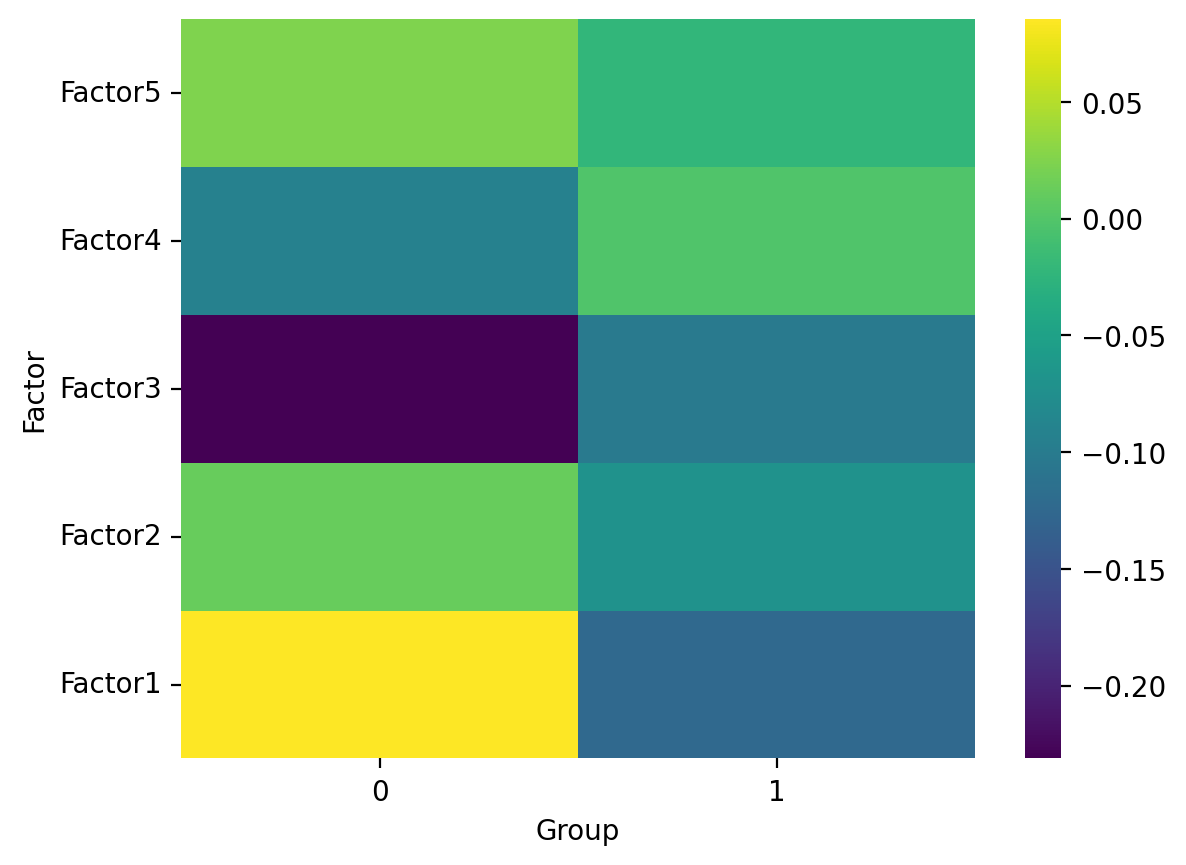

In [66]:
# Average value of factor for each group
mfx.plot_factors_matrix(m, factors=None, group_label=None, groups=None, agg="mean", cmap="viridis", vmin=None, vmax=None)

<Axes: >

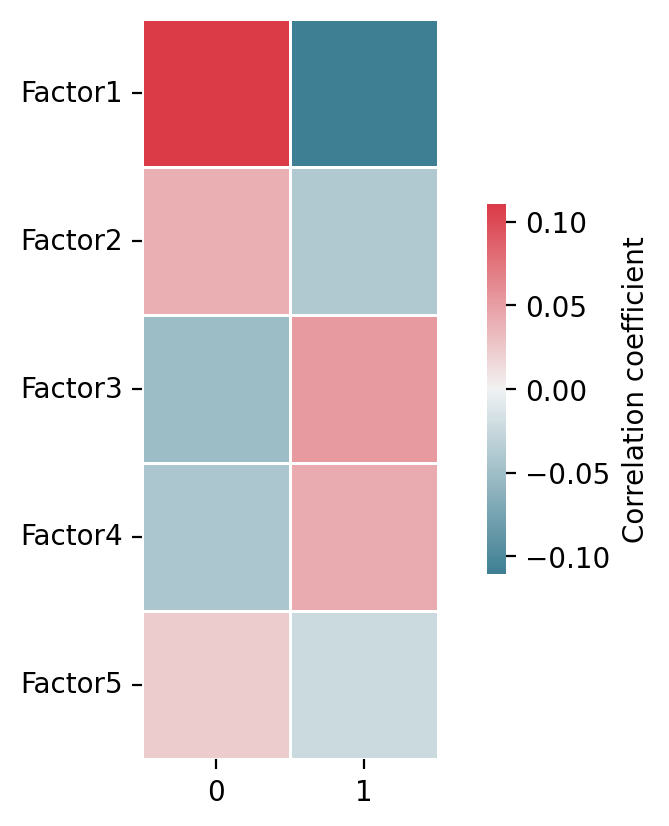

In [67]:
# Correlation between factors and group (outcome)
mfx.plot_factors_covariates_correlation(m, covariates = pd.get_dummies(m.metadata.group), pvalues = False)

<Axes: xlabel='Group', ylabel='R2'>

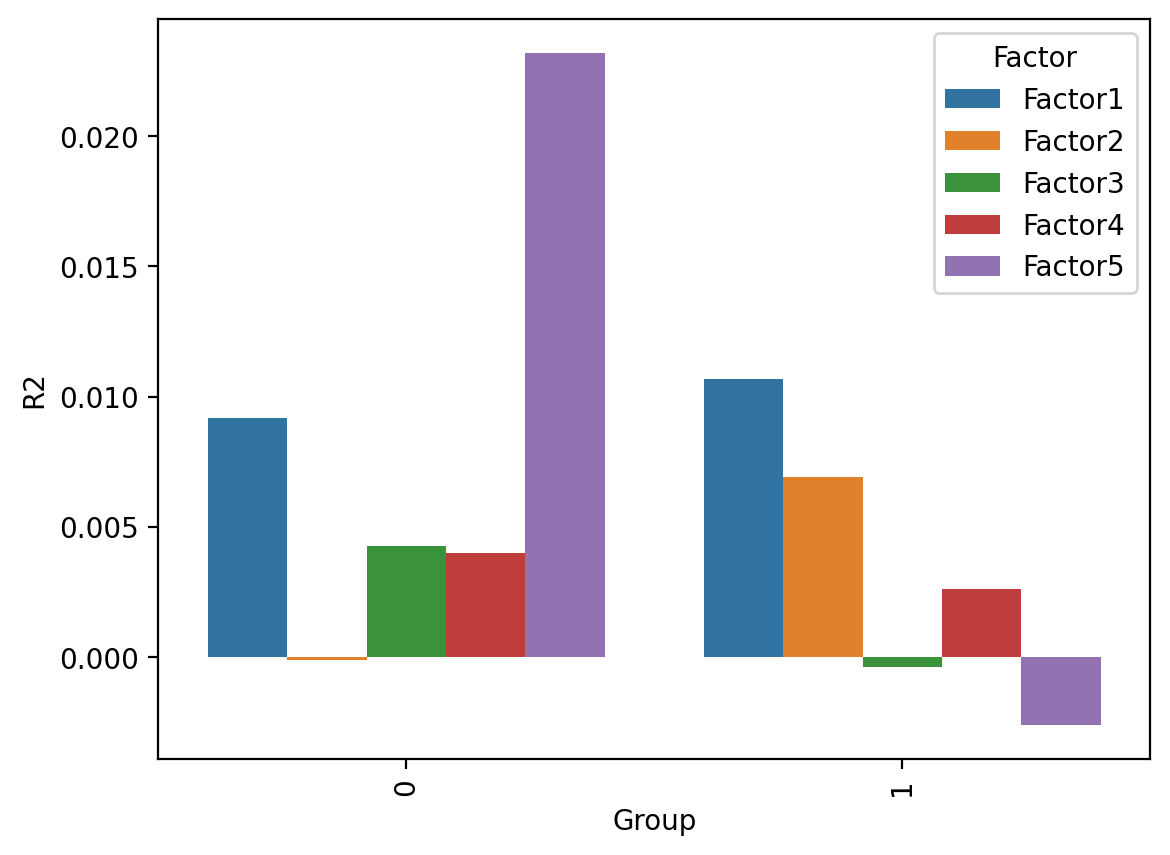

In [68]:
# Variance (R^2) explained by each factor in each group
mfx.plot_r2_barplot(m, factors = None, groups_df = None, group_label = None, x = "Group", y = "R2", groupby = "Factor", xticklabels_size = 10, linewidth = 0, stacked=False)

In [69]:
m.get_weights(factors = 'Factor1', df = True).abs().sort_values(by = "Factor1", ascending = False)

,Factor1
"IL_neg_2_CD4_pos_CD45RA_neg_pSTAT5, subset: CD4+CD45RA-: pSTAT5",0.466574
"IL_neg_10_CD4_pos_CD45RA_neg_pSTAT1, subset: CD4+CD45RA-: pSTAT1",0.374573
"IL_neg_2_CD4_pos_pSTAT5, subset: CD4+: pSTAT5",0.355674
"IL_neg_10_CD4_pos_pSTAT1, subset: CD4+: pSTAT1",0.347325
"IL_neg_10_CD8_pos_CD45RA_pos_pSTAT1, subset: CD8+CD45RA+: pSTAT1",0.334434
...,...
"Unstim_granulocytes_pCREB, subset: CD45+ CD66+: pCREB",0.000000
"Unstim_granulocytes_pp38, subset: CD45+ CD66+: pp38",0.000000
"Unstim_type_2_mDC_pErk1_2, subset: CD45++ CD66low/CD3-/CD123-/type 2 mDC: pErk1_2",0.000000
"IL_neg_21_granulocytes_pSTAT1, subset: CD45+ CD66+: pSTAT1",0.000000


## Getting most weighted features for most important factor

In [70]:
# Number of top features taken from Factor 1
num_top_features = 10

In [71]:
factor_name = "Factor1"

# List of views
views = list(range(len(m.views)))

# Initialize an empty list to store the weights data
weights_list = []

# Iterate through each view to get weights for "Factor1"
for view in views:
    # Get weights for "Factor1" for current view and convert to DataFrame
    w = m.get_weights(views=view, factors=factor_name, df=True)
    # Add an identifier for the current view
    w['view'] = view
    # Append the DataFrame to the list
    weights_list.append(w)

# Concatenate all DataFrames into a single DataFrame
all_weights = pd.concat(weights_list, ignore_index=False)
# Sort the DataFrame by 'Factor1' in descending order
all_w_sorted = all_weights.sort_values(by=factor_name, ascending=False)

# Create a dictionary to map view numbers to assay names
view_to_assay = {
    0: "CBCD",
    1: "CyTOF_phenotyping",
    2: "Luminex_combined",
    3: "Lyoplate_1",
    4: "Other_Luminex",
    5: "Phospho_flow_cytokine_stim_(PBMC)",
    6: "pCyTOF_(whole_blood)_pheno",
    7: "pCyTOF_(whole_blood)_phospho"
}

# Map the view numbers to assay names and create a new column 'assay'
all_w_sorted['assay'] = all_w_sorted['view'].map(view_to_assay)

# Sort by absolute value of weights in 'Factor 1' and select the top 5 rows
absolute_w_weights = all_w_sorted[[factor_name, 'view']].abs()
top_5_features = absolute_w_weights.sort_values(by=factor_name, ascending=False).head(num_top_features)
top_5_feature_names = top_5_features.index.tolist()

# Initialize lists to store the extracted search strings, subset values, and weights
search_strings = []
subset_values = []
weights = []
assay = []

# Extract search_string, subset_value, and weight for each feature name
for feature in top_5_feature_names:
    if "subset: " in feature:
        # Split the string at "subset: " to separate the parts
        parts = feature.split(", subset: ")
        search_strings.append(parts[0])
        subset_values.append(parts[1])
    
    # Add the original weight value (with sign)
    weight = all_w_sorted.loc[feature, factor_name]
    weights.append(weight)

    assay_feature = all_w_sorted.loc[feature, 'assay']
    assay.append(assay_feature)

# Combine the extracted information into a DataFrame for better presentation
result_df = pd.DataFrame({
    "feature": search_strings,
    "subset": subset_values,
    "weight": weights,
    "assay": assay
})

# Print the resulting DataFrame
result_df

,feature,subset,weight,assay
0,IL_neg_2_CD4_pos_CD45RA_neg_pSTAT5,CD4+CD45RA-: pSTAT5,0.466574,Phospho_flow_cytokine_stim_(PBMC)
1,IL_neg_10_CD4_pos_CD45RA_neg_pSTAT1,CD4+CD45RA-: pSTAT1,0.374573,Phospho_flow_cytokine_stim_(PBMC)
2,IL_neg_2_CD4_pos_pSTAT5,CD4+: pSTAT5,0.355674,Phospho_flow_cytokine_stim_(PBMC)
3,IL_neg_10_CD4_pos_pSTAT1,CD4+: pSTAT1,0.347325,Phospho_flow_cytokine_stim_(PBMC)
4,IL_neg_10_CD8_pos_CD45RA_pos_pSTAT1,CD8+CD45RA+: pSTAT1,0.334434,Phospho_flow_cytokine_stim_(PBMC)
5,IFNa_B_cell_pSTAT1,B cell: pSTAT1,0.315769,Phospho_flow_cytokine_stim_(PBMC)
6,IL_neg_10_CD8_pos_pSTAT1,CD8+: pSTAT1,0.312059,Phospho_flow_cytokine_stim_(PBMC)
7,IL_neg_7_CD8_pos_CD45RA_neg_pSTAT5,CD8+CD45RA-: pSTAT5,0.308389,Phospho_flow_cytokine_stim_(PBMC)
8,IL_neg_10_CD8_pos_CD45RA_neg_pSTAT1,CD8+CD45RA-: pSTAT1,0.307261,Phospho_flow_cytokine_stim_(PBMC)
9,IL_neg_2_CD8_pos_CD45RA_neg_pSTAT5,CD8+CD45RA-: pSTAT5,0.294063,Phospho_flow_cytokine_stim_(PBMC)


### Plot p-value graphs for the top five features

In [72]:
from scipy.stats import ttest_ind
import os

# Define the function to perform and plot the analysis
def plot_feature_data(data, search_string, subset_value, weight, save_folder):
    # Filter the data for the specific feature
    top_feature_mofa = data[
        data['feature'].str.contains(search_string, na=False) & 
        (data['subset'] == subset_value)
    ]

    # Get unique view value
    view_value = top_feature_mofa['view'].unique()[0]
    
    # Get min and max values for setting y-limits
    min_value = top_feature_mofa['value'].min()
    max_value = top_feature_mofa['value'].max()

    # Initialize the matplotlib figure
    plt.figure(figsize=(5, 5))

    # Define colors for each group
    colors = {'0': 'lightgray', '1': 'lightcoral'}
    errorbar_colors = {'0': 'black', '1': 'red'}
    
    # Perform the t-test
    group0_values = top_feature_mofa[top_feature_mofa['group'] == '0']['value']
    group1_values = top_feature_mofa[top_feature_mofa['group'] == '1']['value']
    # t_stat, p_value = ttest_ind(group0_values, group1_values)
    t_stat, p_value = ttest_ind(group0_values,
                                group1_values,
                                equal_var=False) # for unequal variances


    # Plot scatter plot with jitter for individual points for each group
    for group in top_feature_mofa['group'].unique():
        group_data = top_feature_mofa[top_feature_mofa['group'] == group]
        sns.violinplot(x='group', y='value', data=group_data, color=colors[group], alpha=0.7)

    # Calculate the mean and standard deviation for each group
    group_stats = top_feature_mofa.groupby('group')['value'].agg(['mean', 'std']).reset_index()

    # Add the error bars after the strip plots to ensure they are not covered
    for _, row in group_stats.iterrows():
        plt.errorbar(x=row['group'], y=row['mean'], yerr=row['std'], fmt='o', color=errorbar_colors[row['group']], capsize=5, capthick=2, elinewidth=2, zorder=3)

    # Add the significance line and asterisk if p-value <= 0.05
    if p_value < 0.05:
        significance_y = max_value + 0.1 * (max_value - min_value)
        plt.plot([0, 1], [significance_y, significance_y], color='black', zorder=2)
        plt.text(0.5, significance_y + 0.05 * (max_value - min_value), '*', ha='center', va='bottom', fontsize=20, color='black', zorder=3)

    # Set the y-axis limits
    plt.ylim(min_value - 0.35 * (max_value - min_value), max_value + 0.35 * (max_value - min_value))  # Adjust limits based on feature values

    # Improve visualization
    title_str = f"View: {view_value}\nFeature: {search_string}\nWeight: {weight:.3f}"
    if p_value < 0.05:
        title_str += f"\n*p-value = {p_value} < 0.05"
    else:
        title_str += f"\np-value {p_value} > 0.05"

    plt.title(title_str, fontsize=12)
    plt.xlabel('Group')
    plt.ylabel('Value')

    # Save the plot as a PNG file        
    filename = f"{view_value}_{search_string}_{weight:.3f}.png"
    filepath = os.path.join(save_folder, filename)
    plt.savefig(filepath, format='png', dpi=300, bbox_inches='tight')

    # Close the plot to free up memory
    plt.close()

# Directory to save plots
save_folder = 'top features for mofa'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Plot each feature from result_df with proper dimensions and adjusted y-limits
for _, row in result_df.iterrows():
    plot_feature_data(
        data=final_mofa_data,
        search_string=row['feature'],
        subset_value=row['subset'],
        weight=row['weight'],
        save_folder=save_folder
    )


## Predicting Outcome Based On Top 5 Features Only

In [73]:
# Transform data in different format, where sample is index and each feature is a column
training_data = filtered_data_mofa.pivot_table(index=['sample', 'group'],
                                           columns=['feature'],
                                           values='value').reset_index().rename_axis(None, axis = 1)

# Isolate only wanted features
selected_training_data = {}
selected_training_data['sample'] = training_data['sample']
selected_training_data['group'] = training_data['group']
for _, row in result_df.iterrows():
    selected_training_data[row['feature']] = training_data[row['feature'] + ", subset: " + row['subset']]
selected_training_data = pd.concat(selected_training_data, axis = 1, ignore_index=False)

selected_training_data = selected_training_data.set_index('sample')

In [74]:
# Split train and test split
train_df, test_df = train_test_split(
    selected_training_data, test_size=0.2, random_state=42, stratify=selected_training_data['group']
)

In [75]:
# Split into X and Y
train_X, train_Y = train_df.drop('group', axis = 1), train_df['group']
test_X, test_Y = test_df.drop('group', axis = 1), test_df['group']

In [76]:
# Impute missing values
def impute_missing_values(df):
    knn_imputer = KNNImputer(n_neighbors=3)
    return pd.DataFrame(knn_imputer.fit_transform(df), columns = df.columns, index = df.index)

train_X_imputed = impute_missing_values(train_X)
test_X_imputed = impute_missing_values(test_X)

In [77]:
# Create and train model
model = LogisticRegression(penalty='elasticnet', max_iter=int(1e6), solver = 'saga', l1_ratio=0.5)
model.fit(train_X_imputed, train_Y)

LogisticRegression(l1_ratio=0.5, max_iter=1000000, penalty='elasticnet',
                   solver='saga')

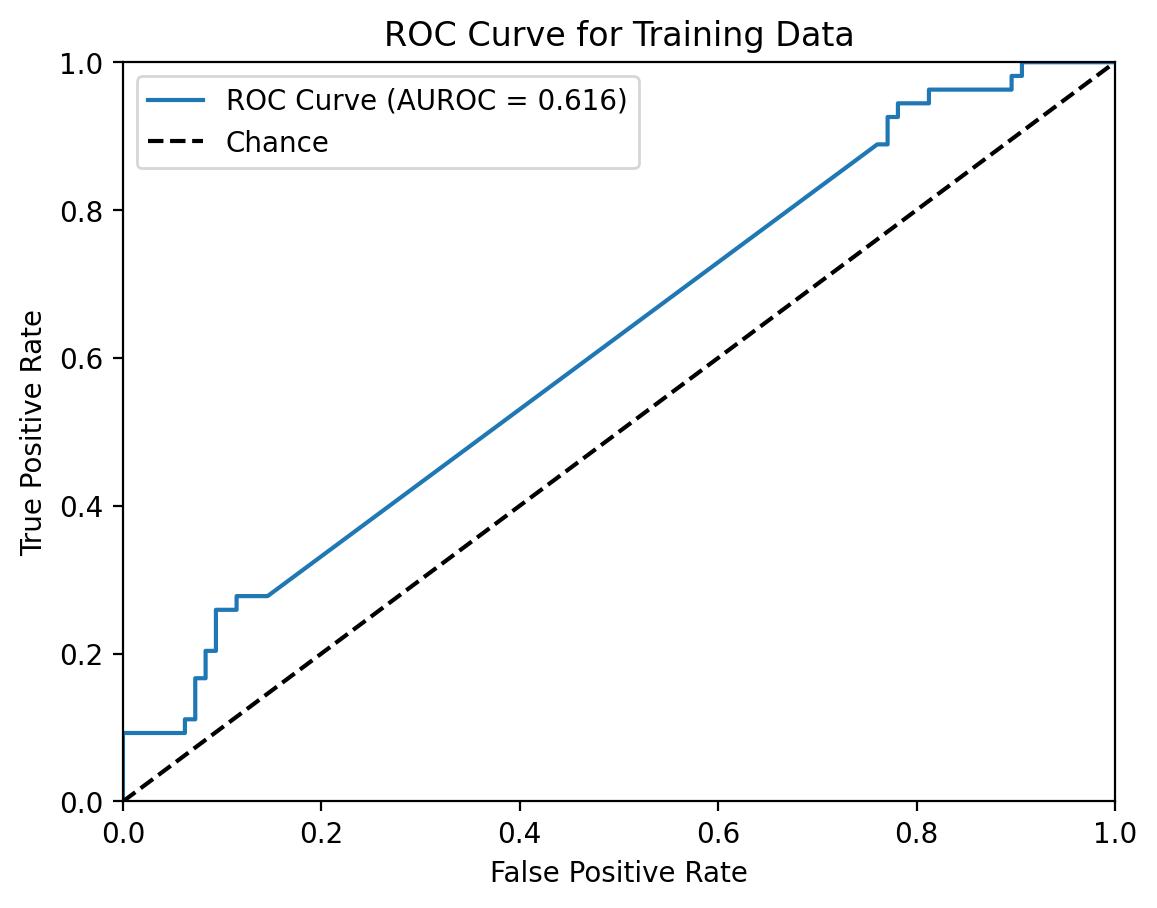

In [78]:
# Model predictions on training data
train_Y_preds = model.predict_proba(train_X_imputed)[:,1]

fpr, tpr, _ = roc_curve(train_Y, train_Y_preds)
roc_auc = auc(fpr, tpr)

# ROC Curve for training data
plt.figure()
plt.plot(fpr, tpr, label = 'ROC Curve (AUROC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0,1], 'k--', label = 'Chance')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.legend()
plt.show()

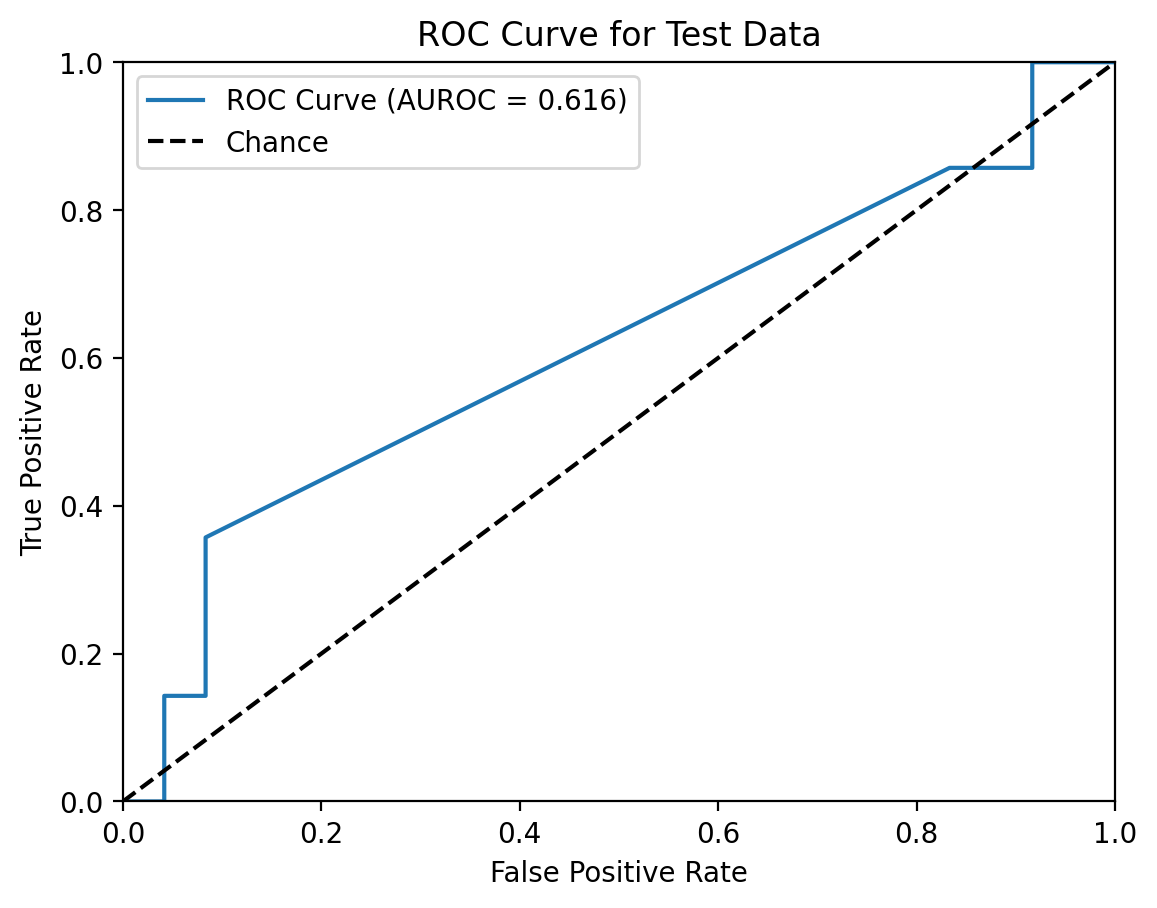

In [79]:
# Model predictions on training data
test_Y_preds = model.predict_proba(test_X_imputed)[:,1]

fpr, tpr, _ = roc_curve(test_Y, test_Y_preds)
roc_auc = auc(fpr, tpr)

# ROC Curve for training data
plt.figure()
plt.plot(fpr, tpr, label = 'ROC Curve (AUROC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0,1], 'k--', label = 'Chance')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data')
plt.legend()
plt.show()